# Heuristicas

In [1]:
import utils
import random

import simulator as sim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm import trange
from typing import List


DATA = "../data/sim.dat"
POWERS = "../data/sim_powers.tsv"

In [2]:
def read_powers() -> pd.DataFrame:
    return pd.read_csv(
        POWERS,
        sep=' ',
        header=None,
        names=["team", "power"],
    )

def read_sim_ranking(path: str):
    powers = read_powers()
    ranking = utils.read_ranking(path)
    ranking["power"] = (ranking.index + 1).map(powers.set_index("team")["power"])
    ranking["team"] = (ranking.index+1)
    return ranking

def randseed() -> int:
    return random.randint(1, 10000)

In [3]:
import lose_heuristic as heur
import HillClimberHeuristic as hill
import min_cmm

# iterar e imprimir boxplot
TEAM_COUNT = 10
SELECTED = 8
ITER = 50
GOALS = 9
POWER_TYPE = "linear" # "exponential"

heuristics = [
    #{ "name": "lose_better",  "fn": heur.lose_better },
    #{ "name": "lose_worse",   "fn": heur.lose_worse  },
    #{ "name": "win_one",      "fn": heur.win_one     },
    #{ "name": "hill_climber", "fn": hill.HillClimber },
    { "name": "none",          "fn": None                   },
    { "name": "min_cmm",       "fn": min_cmm.min_cmm        },
    { "name": "min_cmm_tol_1", "fn": min_cmm.min_cmm_tol_1  },
    { "name": "min_cmm_tol_3", "fn": min_cmm.min_cmm_tol_3  },

]

DATA_FMT = "../data/sim.{}.dat"
RANKING_FMT = DATA_FMT+utils.OUT

results = pd.DataFrame(columns=["rating", "ranking", "wins", "heuristic"])

for i in tqdm(range(ITER)):
    seed = randseed()
    for h in heuristics:
        data = DATA_FMT.format(h["name"])
        ranks = RANKING_FMT.format(h["name"])
        fn = h["fn"]

        # perform the simulation
        sim.simulate(
            team_count=TEAM_COUNT,
            heuristic=fn,
            selected=SELECTED,
            goals_per_game=GOALS,
            matches_output=data,
            seed=seed,
            powers=POWER_TYPE,
        )

        # create the ranking
        utils.run(data, utils.METHOD_CMM, ranks)

        # read the ranking & analyze the data
        ranking = read_sim_ranking(ranks)
        analyzed_data = utils.analyze_data(data)
        srt = ranking.sort_values("rating", ascending=False).reset_index()
        results = results.append({
            "rating": ranking.set_index("team").at[SELECTED, "rating"],
            "ranking": srt[srt["team"] == SELECTED].index[0] + 1,
            "wins": analyzed_data.set_index("team").loc[SELECTED].values[2],
            "heuristic": h["name"]
        }, ignore_index=True)

print("Done!")

  0%|          | 0/50 [00:00<?, ?it/s]

0
0
0


  4%|▍         | 2/50 [00:00<00:15,  3.16it/s]

0
0
0


  6%|▌         | 3/50 [00:00<00:14,  3.24it/s]

0
0
0


  8%|▊         | 4/50 [00:01<00:14,  3.22it/s]

0
0
0


 10%|█         | 5/50 [00:01<00:14,  3.21it/s]

0
0
0


 12%|█▏        | 6/50 [00:01<00:13,  3.31it/s]

0
0
0


 14%|█▍        | 7/50 [00:02<00:12,  3.31it/s]

0
0
0


 18%|█▊        | 9/50 [00:02<00:11,  3.46it/s]

0
0
0


 22%|██▏       | 11/50 [00:03<00:10,  3.69it/s]

0
0
0


 24%|██▍       | 12/50 [00:03<00:10,  3.51it/s]

0
0
0


 26%|██▌       | 13/50 [00:03<00:11,  3.33it/s]

0
0
0


 28%|██▊       | 14/50 [00:04<00:10,  3.29it/s]

0
0
0


 38%|███▊      | 19/50 [00:05<00:07,  3.89it/s]

0
0
0


 40%|████      | 20/50 [00:05<00:08,  3.64it/s]

0
0
0


 42%|████▏     | 21/50 [00:06<00:07,  3.64it/s]

0
0
0


 48%|████▊     | 24/50 [00:06<00:06,  3.85it/s]

0
0
0


 52%|█████▏    | 26/50 [00:07<00:06,  3.73it/s]

0
0
0


 54%|█████▍    | 27/50 [00:07<00:06,  3.64it/s]

0
0
0


 58%|█████▊    | 29/50 [00:08<00:05,  3.53it/s]

0
0
0


 60%|██████    | 30/50 [00:08<00:05,  3.38it/s]

0
0
0


 62%|██████▏   | 31/50 [00:08<00:05,  3.33it/s]

0
0
0


 64%|██████▍   | 32/50 [00:09<00:05,  3.32it/s]

0
0
0


 68%|██████▊   | 34/50 [00:09<00:04,  3.44it/s]

0
0
0


 72%|███████▏  | 36/50 [00:10<00:03,  3.62it/s]

0
0
0


 76%|███████▌  | 38/50 [00:10<00:03,  3.61it/s]

0
0
0


 78%|███████▊  | 39/50 [00:11<00:03,  3.54it/s]

0
0
0


 80%|████████  | 40/50 [00:11<00:02,  3.41it/s]

0
0
0


 82%|████████▏ | 41/50 [00:11<00:02,  3.38it/s]

0
0
0


 84%|████████▍ | 42/50 [00:12<00:02,  3.38it/s]

0
0
0


 86%|████████▌ | 43/50 [00:12<00:02,  3.38it/s]

0
0
0


 88%|████████▊ | 44/50 [00:12<00:01,  3.32it/s]

0
0
0


 90%|█████████ | 45/50 [00:12<00:01,  3.34it/s]

0
0
0


 96%|█████████▌| 48/50 [00:13<00:00,  3.71it/s]

0
0
0


 98%|█████████▊| 49/50 [00:14<00:00,  3.58it/s]

0
0
0


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]

Done!


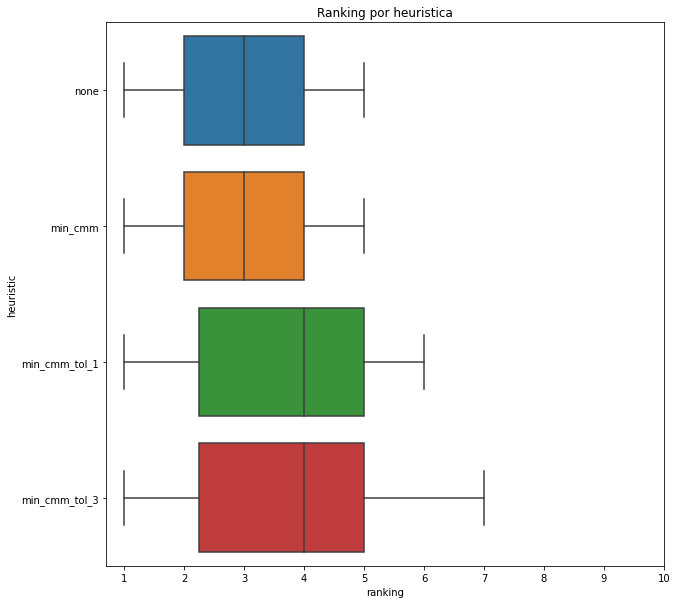

In [4]:
plt.subplots(1, 1, figsize=(10, 10))
plot = sns.boxplot(data=results, x="ranking", y="heuristic")
plot.set_title("Ranking por heuristica")
plot.set_xticks(range(1, TEAM_COUNT+1))
plot

Text(0.5, 1.0, 'Wins por heuristica')

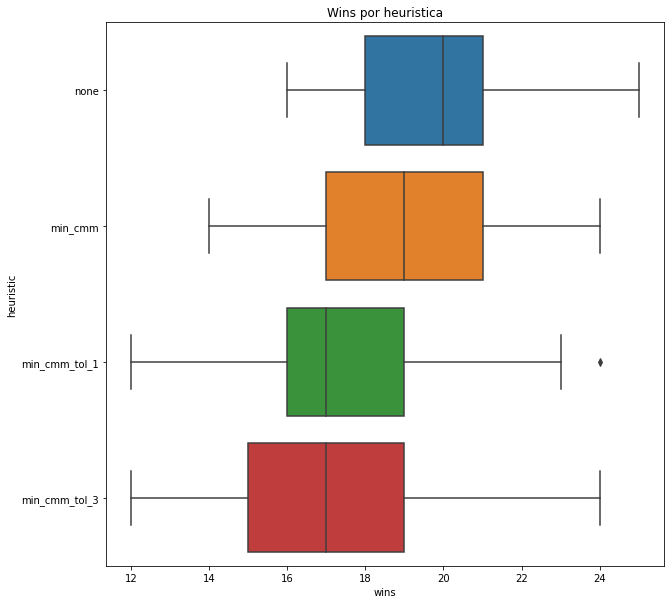

In [5]:
plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=results, x="wins", y="heuristic").set_title("Wins por heuristica")

In [6]:
def rank_progressively(
        weeks: int, # cantidad de semanas
        teams: int, # cantidad de equipos
        seed: int,  # seed del simulador
        heuristic=None,
    ) -> pd.DataFrame:
    
    path = DATA
    # Genero todos los datos
    sim.simulate(
        weeks=weeks,
        team_count=teams,
        heuristic=heuristic,
        selected=SELECTED,
        goals_per_game=GOALS,
        matches_output=path,
        seed=seed,
    )
    
    data = utils.read_mn(path).set_index("date")
    ratings_by_week = pd.DataFrame()

    for week in tqdm(range(1, weeks+1)):
        data_til_week = path + f".week{week}"
        spliced = data.loc[:week]
    
        # Escribo el header con cant equipos y games
        with open(data_til_week, "w") as f:
            print(f"{teams} {spliced.shape[0]}", file=f)

        spliced.to_csv(data_til_week, sep=" ", mode="a", header=False)

        utils.run(data_til_week, utils.METHOD_CMM)
        ranking = read_sim_ranking(data_til_week+utils.METHOD_CMM+utils.OUT)
        ranking["week"] = week
        ratings_by_week = ratings_by_week.append(ranking)

    return ratings_by_week


WEEKS = 20
seed = randseed()
normal = rank_progressively(WEEKS, TEAM_COUNT, seed=seed)
cmm = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm, seed=seed)
cmm_1 = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm_tol_1, seed=seed)
cmm_3 = rank_progressively(WEEKS, TEAM_COUNT, heuristic=min_cmm.min_cmm_tol_3, seed=seed)

print("Done!")

100%|██████████| 20/20 [00:00<00:00, 27.38it/s]


0


100%|██████████| 20/20 [00:00<00:00, 28.98it/s]


0


100%|██████████| 20/20 [00:00<00:00, 27.60it/s]


0


100%|██████████| 20/20 [00:00<00:00, 28.20it/s]

Done!


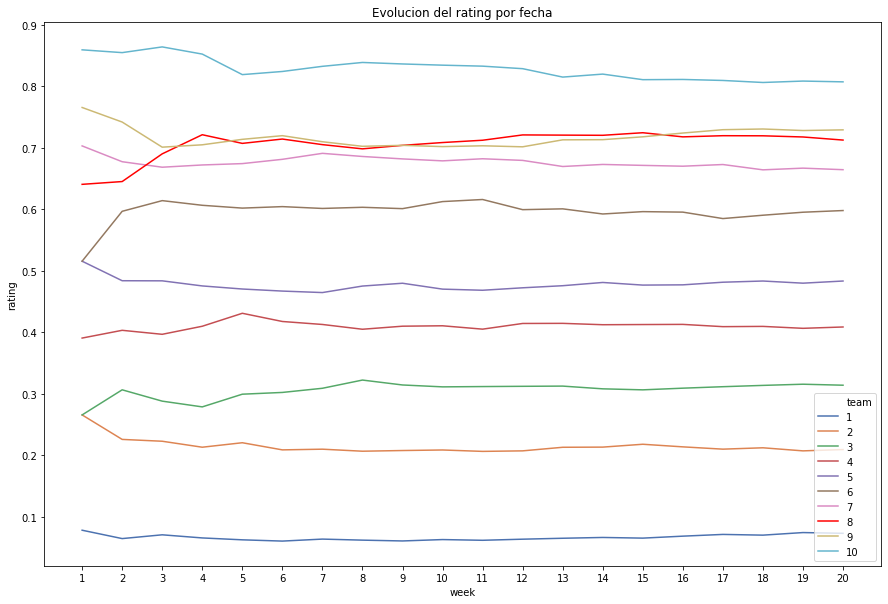

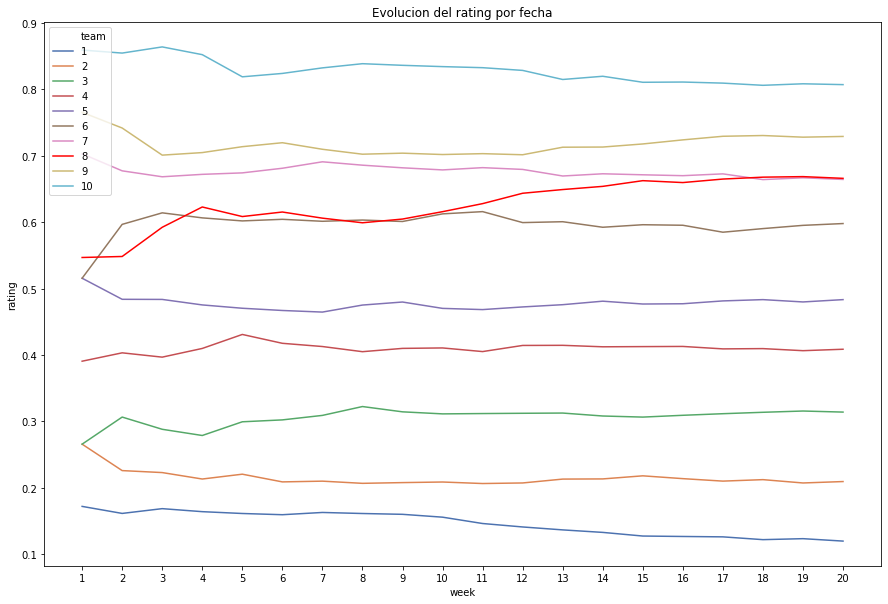

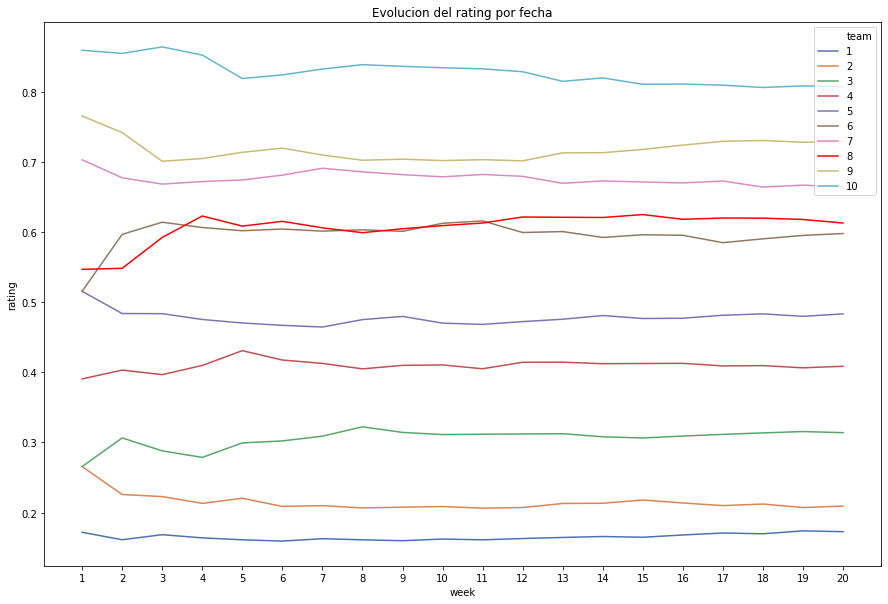

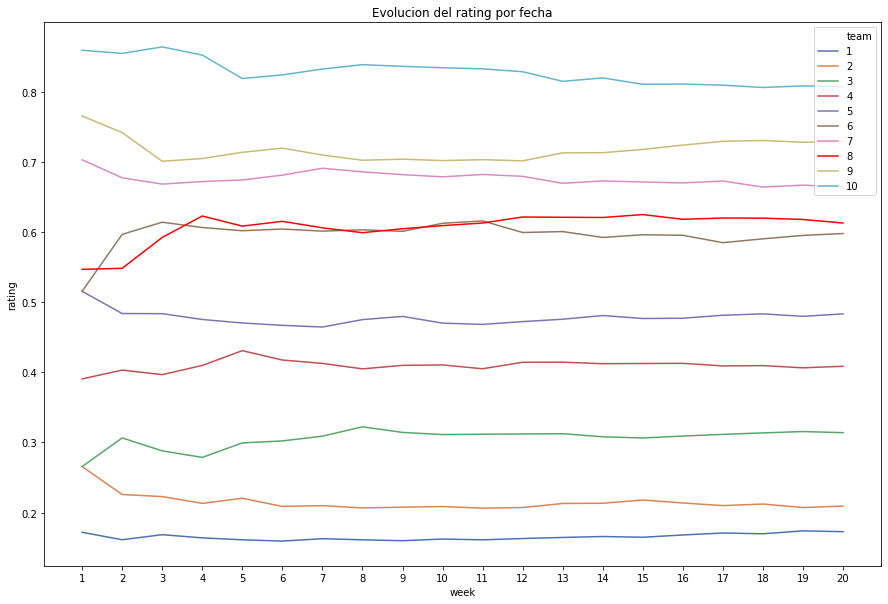

In [15]:
def plot_ratings_by_week(ratings: pd.DataFrame):
    fig, axs = plt.subplots(1, 1, figsize=(15, 10)) 
    palette = sns.color_palette("Blues", TEAM_COUNT)
    palette[SELECTED-1] = "#ff0000"
    plot = sns.lineplot(
        data=ratings, 
        x="week", y="rating", 
        hue="team",
        palette=palette,
        legend="full",
    )
    plot.set_title("Evolucion del rating por fecha")
    plot.set_xticks(range(1, WEEKS + 1))

plot_ratings_by_week(normal)
plot_ratings_by_week(cmm)
plot_ratings_by_week(cmm_1)
plot_ratings_by_week(cmm_3)
